In [1]:
#Khai báo thư viện
from pyspark.sql import SparkSession
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import count, when, isnull
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
#Đọc file csv được thu thập từ trang https://finance.yahoo.com/
spark = SparkSession.builder.getOrCreate()
data = spark.read.csv("D:/IE212/DACK/Model/NVDA.csv", header=True, inferSchema=True)

## 1. Tập dữ liệu

In [3]:
# Chuyển cột "Date" thành index
data = data.withColumn("Date", data["Date"].cast("timestamp"))  # Chuyển định dạng cột "Date" sang timestamp nếu cần
data = data.select("Date", "Open", "High", "Low", "Close", "Adj Close", "Volume").orderBy("Date")

data.show()

+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|               Date|               Open|               High|                Low|              Close|          Adj Close|   Volume|
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+
|1999-01-22 00:00:00|             0.4375| 0.4882810115814209|0.38802099227905273| 0.4101560115814209| 0.3762545883655548|271468800|
|1999-01-25 00:00:00|0.44270798563957214|0.45833298563957214| 0.4101560115814209|           0.453125|0.41567206382751465| 51048000|
|1999-01-26 00:00:00|0.45833298563957214|0.46744799613952637|0.41145798563957214| 0.4179689884185791|0.38342180848121643| 34320000|
|1999-01-27 00:00:00|0.41927099227905273| 0.4296880066394806|0.39583298563957214|0.41666701436042786| 0.3822275400161743| 24436800|
|1999-01-28 00:00:00|0.41666701436042786|0.41927099227905273| 0.412759989500

In [4]:
#Đếm số lượng dòng và cột của dataframe
print('Số dòng: ', data.count())
print('Số cột: ', len(data.columns))

Số dòng:  6279
Số cột:  7


In [5]:
#Kiểm tra số dòng trùng lặp
duplicate_rows_count = data.groupBy(data.columns).count().filter(F.col('count') > 1).count()
print("Số dòng trùng lặp là:", duplicate_rows_count)

Số dòng trùng lặp là: 0


In [6]:
#Kiểm tra giá trị null
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



In [7]:
data.describe().show()

+-------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+
|summary|               Open|              High|                Low|              Close|          Adj Close|             Volume|
+-------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+
|  count|               6279|              6279|               6279|               6279|               6279|               6279|
|   mean|  42.42126455665261|43.190622208063004| 41.621992766173676|  42.43908588019388|  42.17626443417005|6.094320251632425E7|
| stddev|  89.14536251176979| 90.68350524734196|  87.49831298260831|  89.14957133136069|  89.16637028569797|4.359816987143099E7|
|    min|0.34895798563957214|0.3554689884185791|0.33333298563957214|0.34114599227905273|0.31294864416122437|            1968000|
|    max|  502.1600036621094| 505.4800109863281|  494.1199951171875|  504.0899963378906|  504.045

In [8]:
#Chuyển dữ liệu về pandas để thực hiện vẽ biểu đồ
pandas_df =data.toPandas()
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])
pandas_df.set_index('Date', inplace=True)
pandas_df.sort_index(inplace=True)
pandas_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376255,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415672,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383422,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382228,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381033,22752000


<Axes: xlabel='Date'>

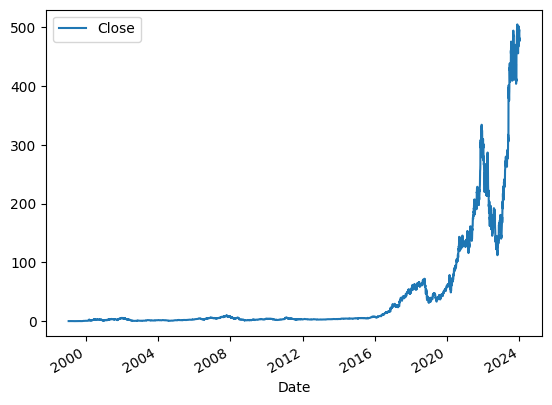

In [9]:
pandas_df.plot.line(y="Close", use_index=True)

<Axes: xlabel='Date'>

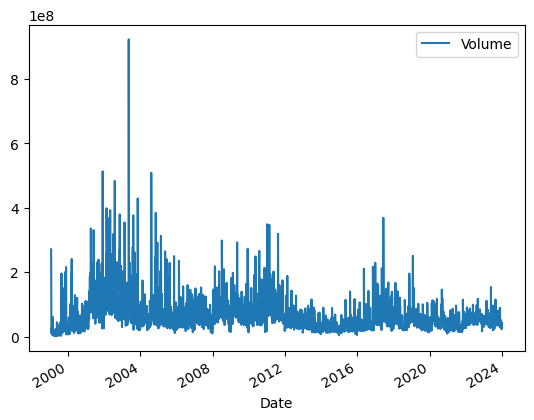

In [10]:
pandas_df.plot.line(y="Volume", use_index=True)

## 2. Chia dữ liệu để huấn luyện mô hình

In [11]:
# Dự đoán 15 ngày sau dựa vào 15 ngày trước.
forecast_out =15
window_spec = Window().orderBy("Date") 
data = data.withColumn("Close_after_n_days", F.lead("Close", forecast_out).over(window_spec))

In [12]:
data.show()

+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+-------------------+
|               Date|               Open|               High|                Low|              Close|          Adj Close|   Volume| Close_after_n_days|
+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+---------+-------------------+
|1999-01-22 00:00:00|             0.4375| 0.4882810115814209|0.38802099227905273| 0.4101560115814209| 0.3762545883655548|271468800|0.43489599227905273|
|1999-01-25 00:00:00|0.44270798563957214|0.45833298563957214| 0.4101560115814209|           0.453125|0.41567206382751465| 51048000|             0.4375|
|1999-01-26 00:00:00|0.45833298563957214|0.46744799613952637|0.41145798563957214| 0.4179689884185791|0.38342180848121643| 34320000| 0.4140630066394806|
|1999-01-27 00:00:00|0.41927099227905273| 0.4296880066394806|0.39583298563957214|0.41666

In [13]:
df = data.toPandas()
df.tail(30)

,Date,Open,High,Low,Close,Adj Close,Volume,Close_after_n_days
6249,2023-11-21,501.260010,505.170013,492.220001,499.440002,499.396088,56574700,480.880005
6250,2023-11-22,498.519989,503.350006,476.899994,487.160004,487.117188,89942000,483.500000
6251,2023-11-24,484.700012,489.209991,477.450012,477.760010,477.718018,29464500,488.899994
6252,2023-11-27,478.000000,485.299988,476.519989,482.420013,482.377594,39566200,500.769989
6253,2023-11-28,482.359985,483.230011,474.730011,478.209991,478.167938,40149100,496.040009
6254,2023-11-29,483.790009,487.619995,478.600006,481.399994,481.357666,38200500,481.109985
6255,2023-11-30,480.239990,481.100006,464.220001,467.700012,467.658905,52624700,489.899994
6256,2023-12-01,465.250000,472.000000,461.869995,467.649994,467.608887,36880900,488.299988
6257,2023-12-04,460.769989,460.769989,450.100006,455.100006,455.059998,43754300,492.790009
6258,2023-12-05,454.660004,466.000000,452.709991,465.660004,465.660004,37171800,494.170013


In [14]:
# New DataFrame with only relevant data
df_new = data.select("Close", "Close_after_n_days")

# Show the resulting DataFrame
df_new.show(30)

+-------------------+-------------------+
|              Close| Close_after_n_days|
+-------------------+-------------------+
| 0.4101560115814209|0.43489599227905273|
|           0.453125|             0.4375|
| 0.4179689884185791| 0.4140630066394806|
|0.41666701436042786|0.42057299613952637|
| 0.4153650104999542|0.43489599227905273|
|0.39583298563957214|             0.4375|
|0.40364599227905273|0.45833298563957214|
|0.37239599227905273|0.49479201436042786|
|0.38020798563957214|0.47916701436042786|
|0.40104201436042786| 0.4570310115814209|
| 0.4127599895000458| 0.4596349895000458|
| 0.3984380066394806|0.45572900772094727|
| 0.3828130066394806|0.42447900772094727|
| 0.3789060115814209| 0.4153650104999542|
|0.41145798563957214|0.43880200386047363|
|0.43489599227905273| 0.4453130066394806|
|             0.4375| 0.4596349895000458|
| 0.4140630066394806|0.45182299613952637|
|0.42057299613952637|0.43229201436042786|
|0.43489599227905273|0.42447900772094727|
|             0.4375|0.44270798563

In [15]:
# Select rows where 'Close_after_n_days' is NaN
df_forecast = df_new.filter(isnull("Close_after_n_days"))
feature_col = ["Close"]
# Vector Assembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_assembled_forecast = assembler.transform(df_forecast).select("features", "Close_after_n_days")
# Show the resulting DataFrame
df_assembled_forecast.show(truncate=False)

+--------------------+------------------+
|features            |Close_after_n_days|
+--------------------+------------------+
|[480.8800048828125] |NULL              |
|[483.5]             |NULL              |
|[488.8999938964844] |NULL              |
|[500.7699890136719] |NULL              |
|[496.0400085449219] |NULL              |
|[481.1099853515625] |NULL              |
|[489.8999938964844] |NULL              |
|[488.29998779296875]|NULL              |
|[492.7900085449219] |NULL              |
|[494.1700134277344] |NULL              |
|[495.2200012207031] |NULL              |
|[495.2200012207031] |NULL              |
|[481.67999267578125]|NULL              |
|[475.69000244140625]|NULL              |
|[479.9800109863281] |NULL              |
+--------------------+------------------+



In [16]:
# All columns of known data except labels, discard last 35 rows
y_col = "Close_after_n_days"
feature_cols = [col for col in df_new.columns if col != y_col]
df_features = df_new.select(*feature_cols, "Close_after_n_days").limit(df_new.count() - forecast_out)

# Vector Assembler to combine feature columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_assembled = assembler.transform(df_features).select("features", "Close_after_n_days")

In [17]:
df_features.toPandas().tail(10)

,Close,Close_after_n_days
6254,481.399994,481.109985
6255,467.700012,489.899994
6256,467.649994,488.299988
6257,455.100006,492.790009
6258,465.660004,494.170013
6259,455.029999,495.220001
6260,465.959991,495.220001
6261,475.059998,481.679993
6262,466.269989,475.690002
6263,476.570007,479.980011


In [18]:
df_assembled.show(truncate=False)

+---------------------+-------------------+
|features             |Close_after_n_days |
+---------------------+-------------------+
|[0.4101560115814209] |0.43489599227905273|
|[0.453125]           |0.4375             |
|[0.4179689884185791] |0.4140630066394806 |
|[0.41666701436042786]|0.42057299613952637|
|[0.4153650104999542] |0.43489599227905273|
|[0.39583298563957214]|0.4375             |
|[0.40364599227905273]|0.45833298563957214|
|[0.37239599227905273]|0.49479201436042786|
|[0.38020798563957214]|0.47916701436042786|
|[0.40104201436042786]|0.4570310115814209 |
|[0.4127599895000458] |0.4596349895000458 |
|[0.3984380066394806] |0.45572900772094727|
|[0.3828130066394806] |0.42447900772094727|
|[0.3789060115814209] |0.4153650104999542 |
|[0.41145798563957214]|0.43880200386047363|
|[0.43489599227905273]|0.4453130066394806 |
|[0.4375]             |0.4596349895000458 |
|[0.4140630066394806] |0.45182299613952637|
|[0.42057299613952637]|0.43229201436042786|
|[0.43489599227905273]|0.4244790

In [19]:
# Here, we're using a time-based split - 80% for training and 20% for testing
train_count = int(df_assembled.count() * 0.8)
df_train = df_assembled.limit(train_count)
df_test = df_assembled.subtract(df_train)

In [20]:
df_train.show()

+--------------------+-------------------+
|            features| Close_after_n_days|
+--------------------+-------------------+
|[0.4101560115814209]|0.43489599227905273|
|          [0.453125]|             0.4375|
|[0.4179689884185791]| 0.4140630066394806|
|[0.41666701436042...|0.42057299613952637|
|[0.4153650104999542]|0.43489599227905273|
|[0.39583298563957...|             0.4375|
|[0.40364599227905...|0.45833298563957214|
|[0.37239599227905...|0.49479201436042786|
|[0.38020798563957...|0.47916701436042786|
|[0.40104201436042...| 0.4570310115814209|
|[0.4127599895000458]| 0.4596349895000458|
|[0.3984380066394806]|0.45572900772094727|
|[0.3828130066394806]|0.42447900772094727|
|[0.3789060115814209]| 0.4153650104999542|
|[0.41145798563957...|0.43880200386047363|
|[0.43489599227905...| 0.4453130066394806|
|            [0.4375]| 0.4596349895000458|
|[0.4140630066394806]|0.45182299613952637|
|[0.42057299613952...|0.43229201436042786|
|[0.43489599227905...|0.42447900772094727|
+----------

In [21]:
df_test.show()

+--------------------+------------------+
|            features|Close_after_n_days|
+--------------------+------------------+
|[33.775001525878906]| 37.61000061035156|
| [32.39250183105469]|37.467498779296875|
|[31.770000457763672]|37.209999084472656|
|[33.275001525878906]| 37.93000030517578|
| [32.79249954223633]| 39.23249816894531|
|[33.412498474121094]|37.192501068115234|
|            [33.375]|  37.3224983215332|
| [34.05500030517578]|39.459999084472656|
|[31.997499465942383]|40.037498474121094|
| [34.04750061035156]|34.502498626708984|
|[35.849998474121094]|32.900001525878906|
| [34.95750045776367]| 34.34749984741211|
| [35.64500045776367]|           35.9375|
|[36.307498931884766]|36.182498931884766|
| [37.20750045776367]| 37.29499816894531|
| [37.61000061035156]| 37.48749923706055|
|[37.467498779296875]|             38.25|
|[37.209999084472656]| 36.85499954223633|
| [37.93000030517578]| 37.04249954223633|
| [39.23249816894531]| 36.61249923706055|
+--------------------+------------

## 3. Xây dựng mô hình GBT

In [22]:
GBT = GBTRegressor (featuresCol="features", labelCol="Close_after_n_days")

In [23]:
model = GBT.fit(df_train)

### 3.1 Kiểm tra tập test

In [24]:
predic_test = model.transform(df_test)

In [25]:
print(predic_test.show())

+--------------------+------------------+-----------------+
|            features|Close_after_n_days|       prediction|
+--------------------+------------------+-----------------+
|[33.775001525878906]| 37.61000061035156|34.44197206627117|
| [32.39250183105469]|37.467498779296875|34.44197206627117|
|[31.770000457763672]|37.209999084472656|34.44197206627117|
|[33.275001525878906]| 37.93000030517578|34.44197206627117|
| [32.79249954223633]| 39.23249816894531|34.44197206627117|
|[33.412498474121094]|37.192501068115234|34.44197206627117|
|            [33.375]|  37.3224983215332|34.44197206627117|
| [34.05500030517578]|39.459999084472656|34.44197206627117|
|[31.997499465942383]|40.037498474121094|34.44197206627117|
| [34.04750061035156]|34.502498626708984|34.44197206627117|
|[35.849998474121094]|32.900001525878906|34.44197206627117|
| [34.95750045776367]| 34.34749984741211|34.44197206627117|
| [35.64500045776367]|           35.9375|34.44197206627117|
|[36.307498931884766]|36.182498931884766

In [26]:
evaluator_rmse = RegressionEvaluator(labelCol="Close_after_n_days", predictionCol="prediction", metricName="rmse")
rmse_test = evaluator_rmse.evaluate(predic_test)
print("Root Mean Squared Error (RMSE) on test data =", rmse_test)

evaluator_rmse = RegressionEvaluator(labelCol="Close_after_n_days", predictionCol="prediction", metricName="r2")
r2_test = evaluator_rmse.evaluate(predic_test)
print("R2 on test data =", r2_test)

Root Mean Squared Error (RMSE) on test data = 171.09388181325153
R2 on test data = -0.8669906895433106


In [27]:
from pyspark.sql.functions import abs

def calculate_mape(df, labelCol, predictionCol):
    df = df.withColumn("absolute_error", abs(df[labelCol] - df[predictionCol]))
    df = df.withColumn("percentage_error", df["absolute_error"] / df[labelCol] * 100)
    mape = df.select("percentage_error").agg({"percentage_error": "avg"}).collect()[0][0]
    return mape

mape_test = calculate_mape(predic_test, "Close_after_n_days", "prediction")
print("Mean Absolute Percentage Error (MAPE) on test data =", mape_test)

Mean Absolute Percentage Error (MAPE) on test data = 51.86023954601548


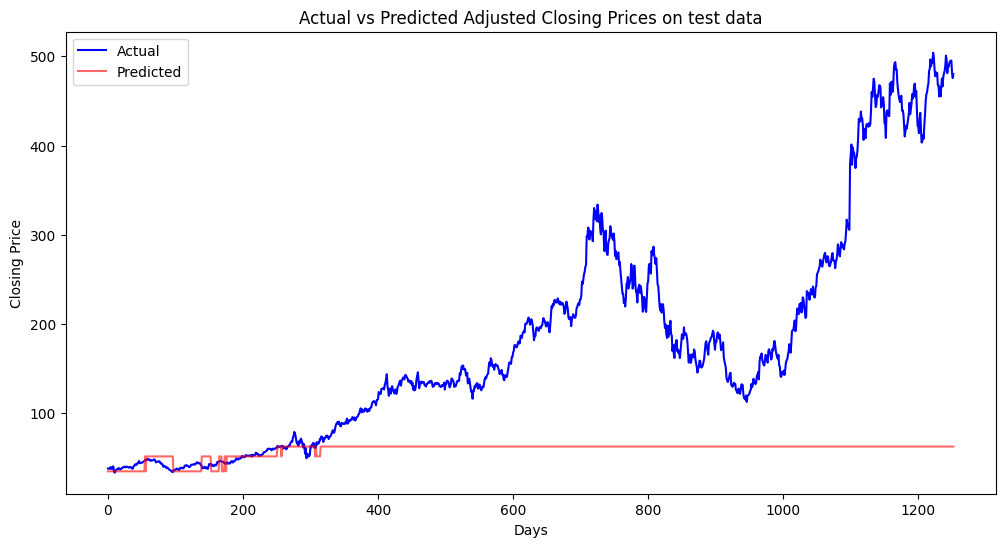

In [28]:
# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predic_test.select("Close_after_n_days", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Close_after_n_days"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Adjusted Closing Prices on test data')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

### 3.2 Kiểm tra tập train

In [29]:
predic_train = model.transform(df_train)

In [30]:
predic_train.show()

+--------------------+-------------------+------------------+
|            features| Close_after_n_days|        prediction|
+--------------------+-------------------+------------------+
|[0.4101560115814209]|0.43489599227905273|0.4560674183232316|
|          [0.453125]|             0.4375|0.4560674183232316|
|[0.4179689884185791]| 0.4140630066394806|0.4560674183232316|
|[0.41666701436042...|0.42057299613952637|0.4560674183232316|
|[0.4153650104999542]|0.43489599227905273|0.4560674183232316|
|[0.39583298563957...|             0.4375|0.4560674183232316|
|[0.40364599227905...|0.45833298563957214|0.4560674183232316|
|[0.37239599227905...|0.49479201436042786|0.4560674183232316|
|[0.38020798563957...|0.47916701436042786|0.4560674183232316|
|[0.40104201436042...| 0.4570310115814209|0.4560674183232316|
|[0.4127599895000458]| 0.4596349895000458|0.4560674183232316|
|[0.3984380066394806]|0.45572900772094727|0.4560674183232316|
|[0.3828130066394806]|0.42447900772094727|0.4560674183232316|
|[0.3789

In [31]:
evaluator_rmse = RegressionEvaluator(labelCol="Close_after_n_days", predictionCol="prediction", metricName="rmse")
rmse_train = evaluator_rmse.evaluate(predic_train)
print("Root Mean Squared Error (RMSE) on train data =", rmse_train)

evaluator_rmse = RegressionEvaluator(labelCol="Close_after_n_days", predictionCol="prediction", metricName="r2")
r2_train = evaluator_rmse.evaluate(predic_train)
print("R2 on train data =", r2_train)

Root Mean Squared Error (RMSE) on train data = 2.2375004130569285
R2 on train data = 0.9752808096127052


In [32]:
from pyspark.sql.functions import abs

def calculate_mape(df, labelCol, predictionCol):
    df = df.withColumn("absolute_error", abs(df[labelCol] - df[predictionCol]))
    df = df.withColumn("percentage_error", df["absolute_error"] / df[labelCol] * 100)
    mape = df.select("percentage_error").agg({"percentage_error": "avg"}).collect()[0][0]
    return mape

mape_train = calculate_mape(predic_train, "Close_after_n_days", "prediction")
print("Mean Absolute Percentage Error (MAPE) on train data =", mape_train)

Mean Absolute Percentage Error (MAPE) on train data = 12.538103979271561


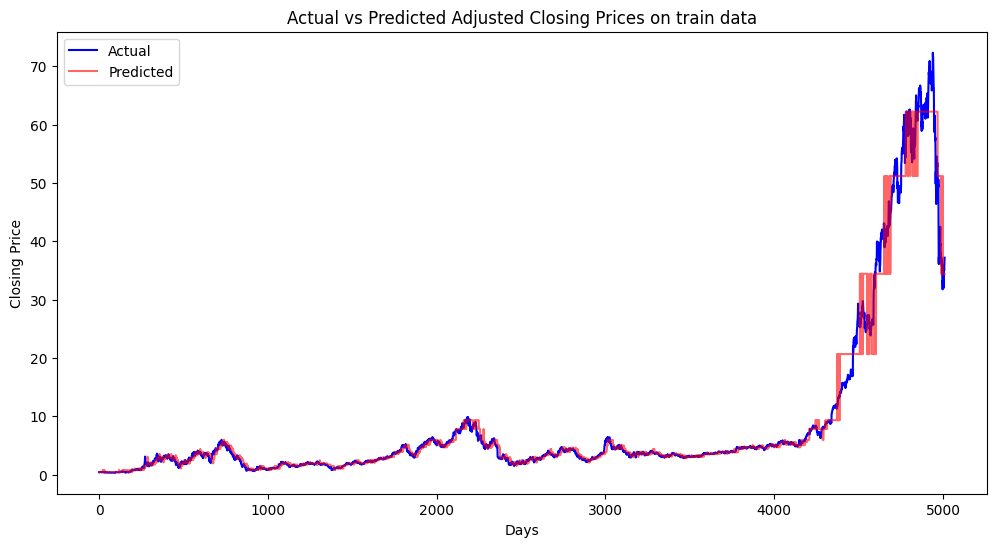

In [33]:
# Visualization
# Plot the actual vs predicted values for adjusted closing prices
preds = predic_train.select("Close_after_n_days", "prediction").toPandas()
plt.figure(figsize=(12, 6))
plt.plot(preds["Close_after_n_days"], label='Actual', color='blue')
plt.plot(preds["prediction"], label='Predicted', color='red', alpha=0.6)
plt.title('Actual vs Predicted Adjusted Closing Prices on train data')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()